In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd src

/Users/purzelrakete/src/github.com/feldberlin/timething/src


In [2]:
from pathlib import Path

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from timething import dataset, job, text, utils, align, viz 

# Timething API

Here's an example use of the Timething API. Let's use it to take a look at the alignment for a single track. Let's set up:

In [3]:
# config
fixtures_path = Path("../fixtures")
aligments_path = fixtures_path / "alignments"
metadata = fixtures_path / "text.csv"
cfg = utils.load_config("english")
device = "cpu"

# aligner
ds = dataset.SpeechDataset(Path(metadata), cfg.sampling_rate)
aligner = align.Aligner.build(device, cfg)
ds.clean_text_fn = text.TextCleaner(cfg.language, aligner.vocab())

# loader
loader = DataLoader(
    ds,
    batch_size=3,
    num_workers=1,
    collate_fn=dataset.collate_fn,
    shuffle=False,
)

Let's pull up some recordings:

In [4]:
xs, ys, ys_original, ids  = next(iter(loader))

In [5]:
for y, y_original, id in zip(ys, ys_original, ids):
    print(f"{id}: '{y_original}'. Cleaned: '{y}'")
    display(ipd.Audio(fixtures_path / id))

audio/one.mp3: 'One!'. Cleaned: 'one'


audio/two.mp3: 'Two?'. Cleaned: 'two'


audio/born.mp3: 'Born in 1969 in Belgrade.'. Cleaned: 'born|in|nineteen|sixty-nine|in|belgrade'


Let's align them.

In [6]:
alignments = aligner.align((xs, ys, ys_original))

/usr/local/Caskroom/miniforge/base/envs/timething/lib/python3.9/site-packages/transformers-4.4.2-py3.8.egg/transformers/models/wav2vec2/modeling_wav2vec2.py:704: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


The last example: Born in 1969 in Belgrade:

In [7]:
recording_idx = 2
id = ids[recording_idx]
y = ys[recording_idx]
y_original = ys_original[recording_idx]
alignment = alignments[recording_idx]

First let's take a look at the frame-wise log probabilities.

Visualisations taken from the [pytorch alignment tutorial](https://pytorch.org/tutorials/intermediate/forced_alignment_with_torchaudio_tutorial.html), Original Author: Moto Hira <moto@fb.com>.

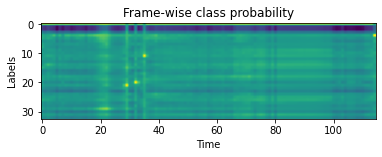

In [8]:
plt.imshow(alignment.log_probs[0].T)
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels");

The probability trellis for this recording:

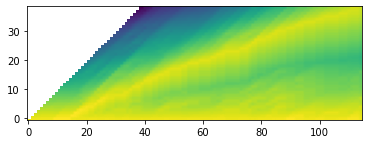

In [9]:
plt.imshow(alignment.trellis[1:, 1:].T, origin="lower");

The best path through the trellis:

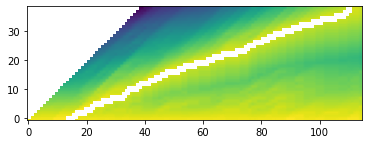

In [10]:
viz.plot_trellis_with_path(alignment.trellis, alignment.path);

The cleaned aligned characters:

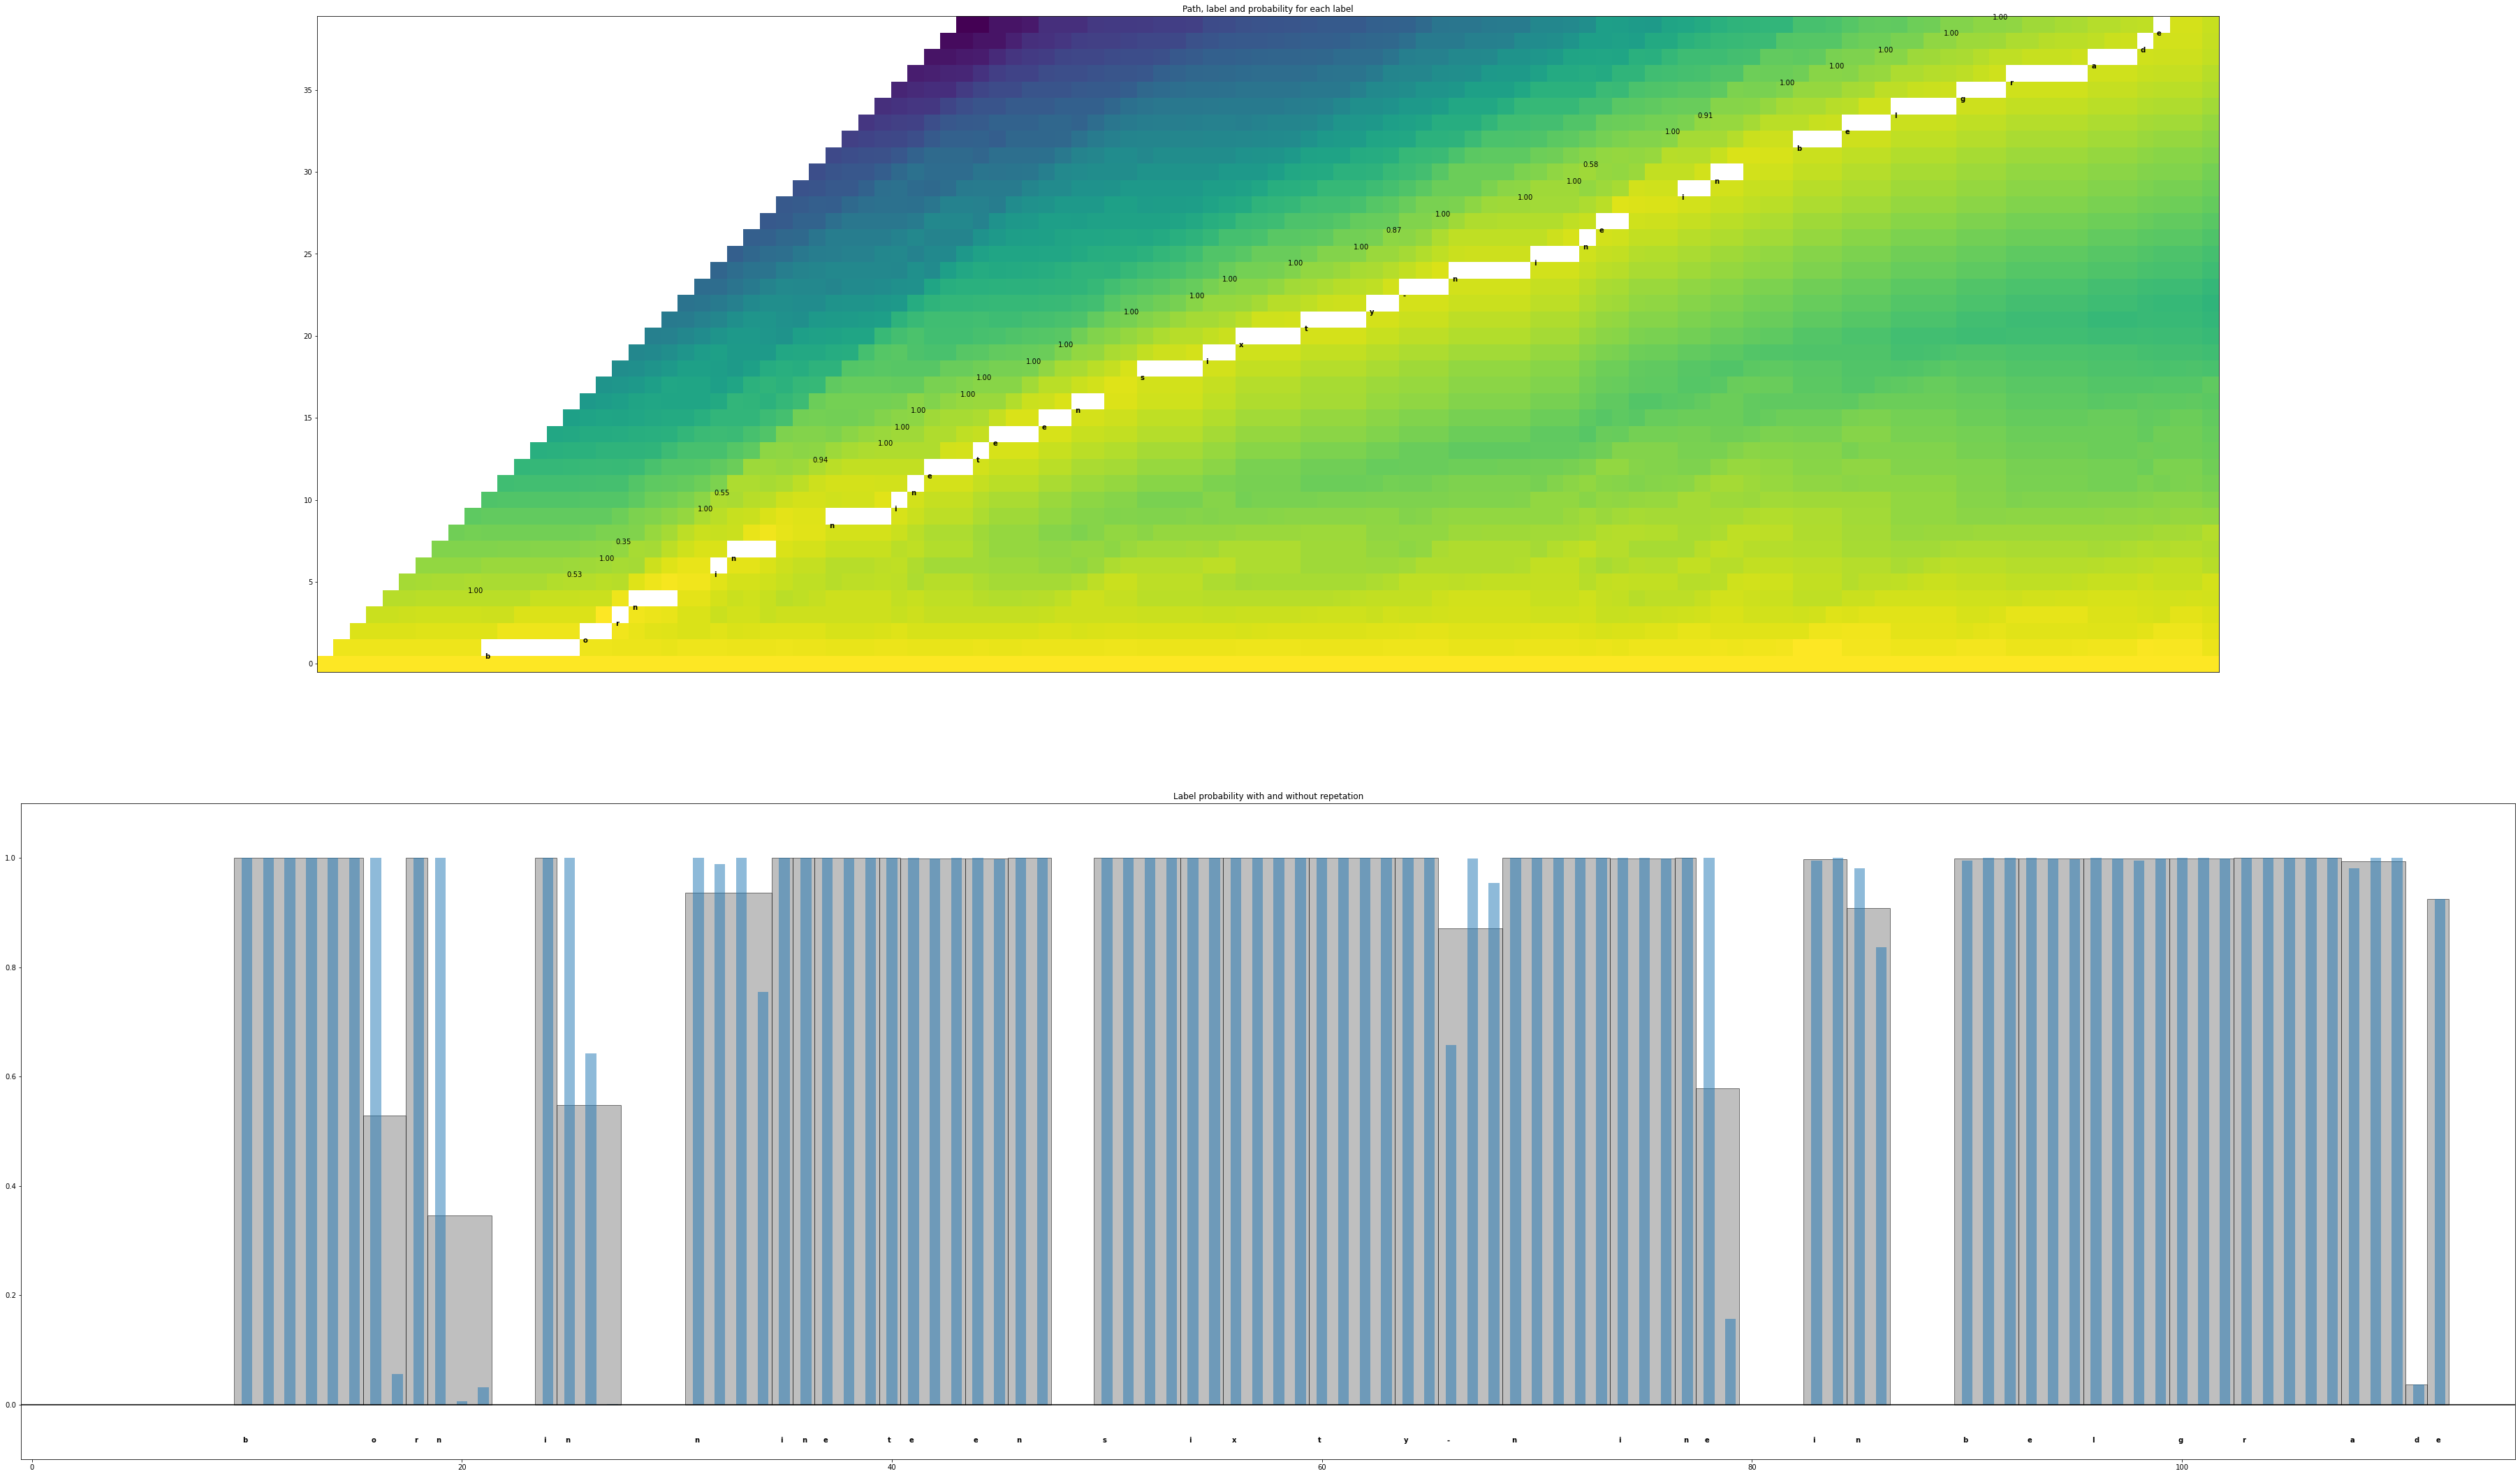

In [11]:
viz.plot_trellis_with_segments(alignment.trellis, alignment.chars_cleaned, y, alignment.path);

In [12]:
alignment.chars_cleaned

[Segment(label='b', start=9, end=15, score=0.9999964833259583),
 Segment(label='o', start=15, end=17, score=0.5280090402811766),
 Segment(label='r', start=17, end=18, score=0.9998226761817932),
 Segment(label='n', start=18, end=21, score=0.3455629236996174),
 Segment(label='|', start=21, end=23, score=0.994437575340271),
 Segment(label='i', start=23, end=24, score=0.9998927116394043),
 Segment(label='n', start=24, end=27, score=0.5476115901886563),
 Segment(label='|', start=27, end=30, score=0.6686613199611505),
 Segment(label='n', start=30, end=34, score=0.9358920753002167),
 Segment(label='i', start=34, end=35, score=0.9999502897262573),
 Segment(label='n', start=35, end=36, score=0.9999912977218628),
 Segment(label='e', start=36, end=39, score=0.9997092485427856),
 Segment(label='t', start=39, end=40, score=0.9999798536300659),
 Segment(label='e', start=40, end=43, score=0.9994089603424072),
 Segment(label='e', start=43, end=45, score=0.9990609288215637),
 Segment(label='n', start=4

In [13]:
alignment.words_cleaned

[Segment(label='born', start=9, end=21, score=0.7915273984628064),
 Segment(label='in', start=23, end=27, score=0.6641016345841179),
 Segment(label='nineteen', start=30, end=47, score=0.9373990712981475),
 Segment(label='sixty-nine', start=49, end=79, score=0.9432110154267513),
 Segment(label='in', start=82, end=86, score=0.8409768108810697),
 Segment(label='belgrade', start=89, end=112, score=0.9532575600821039)]

In [14]:
padding_ms = 20
padding_seconds = padding_ms / 1000

def show_words(words):
    for word in words:
        start_seconds = max(0, alignment.model_frames_to_seconds(word.start) + padding_seconds)
        end_seconds = alignment.model_frames_to_seconds(word.end) + padding_seconds
        y, sr = utils.load_slice(fixtures_path / id, start_seconds, end_seconds)
        print(f"{word.label} ({word.start}:{word.end})")
        ipd.display(ipd.Audio(y, rate=sr))
        
show_words(alignment.words_cleaned)

born (9:21)


in (23:27)


nineteen (30:47)


sixty-nine (49:79)


in (82:86)


belgrade (89:112)


Looks reasonable. Now for the original versions:

In [15]:
alignment.chars

[Segment(label='B', start=9, end=15, score=0.9999964833259583),
 Segment(label='o', start=15, end=17, score=0.5280090402811766),
 Segment(label='r', start=17, end=18, score=0.9998226761817932),
 Segment(label='n', start=18, end=21, score=0.3455629236996174),
 Segment(label=' ', start=21, end=23, score=0.994437575340271),
 Segment(label='i', start=23, end=24, score=0.9998927116394043),
 Segment(label='n', start=24, end=27, score=0.5476115901886563),
 Segment(label=' ', start=27, end=30, score=0.6686613199611505),
 Segment(label='1969', start=30, end=79, score=0.9358920753002167),
 Segment(label=' ', start=79, end=82, score=0.7869421044985453),
 Segment(label='i', start=82, end=84, score=0.9976382255554199),
 Segment(label='n', start=84, end=86, score=0.908625990152359),
 Segment(label=' ', start=86, end=89, score=0.6914364149173101),
 Segment(label='B', start=89, end=92, score=0.9984040458997091),
 Segment(label='e', start=92, end=95, score=0.9990975658098856),
 Segment(label='l', start

In [16]:
alignment.words

[Segment(label='Born', start=9, end=21, score=0.7915273984628064),
 Segment(label='in', start=23, end=27, score=0.6641016345841179),
 Segment(label='1969', start=30, end=79, score=0.9272988077539664),
 Segment(label='in', start=82, end=86, score=0.8409768108810697),
 Segment(label='Belgrade.', start=89, end=112, score=0.9532575600821039)]

In [17]:
show_words(alignment.words)

Born (9:21)


in (23:27)


1969 (30:79)


in (82:86)


Belgrade. (89:112)
